![](https://cdn3.vectorstock.com/i/1000x1000/98/02/set-of-monochrome-icons-with-kannada-numbers-vector-15469802.jpg)

### 导入库

In [2]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


### 加载数据

In [3]:
train=pd.read_csv('../input/Kannada-MNIST/train.csv')
test=pd.read_csv('../input/Kannada-MNIST/test.csv')
sample_sub=pd.read_csv('../input/Kannada-MNIST/sample_submission.csv')

### 初步了解数据

In [4]:
print('训练数据有 {} 行和 {} 列'.format(train.shape[0],train.shape[1]))
print('测试数据有 {} 行和 {} 列'.format(test.shape[0],test.shape[1]))


训练数据有 60000 行和 785 列
测试数据有 5000 行和 785 列


In [5]:
train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


现在可以看到给定的训练数据集中有785列。将在这里描述每一列的含义：

- Label：这一列包含了我们要预测的标签，即目标值。这里的标签是从0到9的数字。我们稍后会绘制一个条形图，看看这些目标值的分布情况。
- Pixel0到Pixel783：这些是图像矩阵的像素值。也就是说，每一行包含28 x 28 = 784个（在这里是0到783）值。每一个值表示图像矩阵中第i x 28 + j个像素位置的像素值


In [6]:
test.head(3)
test=test.drop('id',axis=1)


### 确认类别分布


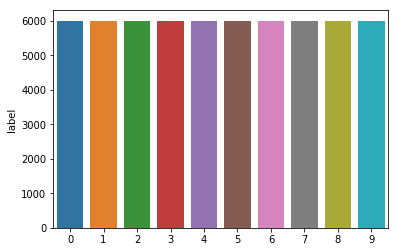

In [7]:
y=train.label.value_counts()
sns.barplot(y.index,y)

可以看到每个类别都被分到6000个示例

## 数据准备

In [8]:
X_train=train.drop('label',axis=1)
Y_train=train.label

print(X_train)
print(Y_train)

       pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
59995       0       0       0       0       0       0       0       0       0   
59996       0       0       0       0       0       0       0       0       0   
59997       0       0       0       0       0       0       0       0       0   
59998       0       0       0       0       0       0       0       0       0   
59999       0       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel77

### 数据归一化

对于大多数图像数据，像素值是0到255之间的整数。

神经网络使用较小的权重值来处理输入，而具有大整数值的输入会干扰或减慢学习过程。因此，将像素值归一化，使每个像素值在0到1之间是一个良好的做法。

将像素值范围设为0-1是合理的，并且图像仍然可以正常显示。

这可以通过将所有像素值除以最大的像素值，即255来实现。这一操作适用于所有通道，无论图像中实际存在的像素值范围如何。

In [9]:
X_train=X_train/255
test=test/255

### 调整尺寸

In [10]:
print('训练数据的形状为',X_train.shape)
print('测试数据的形状为',test.shape)


X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)


print('训练数据的形状为',X_train.shape)
print('测试数据的形状为',test.shape)

训练数据的形状为 (60000, 784)
测试数据的形状为 (5000, 784)
训练数据的形状为 (60000, 28, 28, 1)
测试数据的形状为 (5000, 28, 28, 1)


一切就绪，我们将数据重塑为 60000 个高度 28、宽度 28 和 1 个通道的示例

### 对类别进行编码

对于标签数据，进行one-hot编码

在神经网络中，one-hot编码有助于模型更好地理解和学习数据的类别特征。通过将每个类别分开表示，神经网络可以更有效地调整权重，以学习到类别间的关系。

In [11]:
print(Y_train)
Y_train=to_categorical(Y_train)
print(Y_train)

0        0
1        1
2        2
3        3
4        4
        ..
59995    5
59996    6
59997    7
59998    8
59999    9
Name: label, Length: 60000, dtype: int64
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


### 划分训练集和验证集

现在把训练数据拆分为训练集和验证集。15%的训练数据将用于验证目的。

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X_train,Y_train,random_state=42,test_size=0.15)

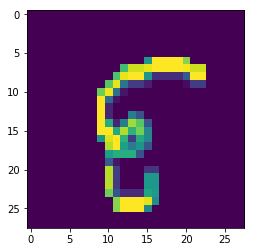

In [13]:
plt.imshow(X_train[0][:,:,0])

### 数据增强

为了避免过拟合问题，我们需要对手写数字数据集进行人工扩展。我们可以使现有的数据集变得更大。这个想法是通过小的变换来改变训练数据，以再现人们书写数字时可能发生的变化。

例如，数字可能没有居中，比例不一致（有些人写大数字，有些人写小数字），图像可能旋转过...

这些以保持标签不变的方式改变数组表示的训练数据的方法被称为数据增强技术。一些常用的数据增强方法包括灰度处理、水平翻转、垂直翻转、随机裁剪、颜色抖动、平移、旋转等。

通过对我们的训练数据应用这些变换中的几种，我们可以轻松地将训练样本数量增加一倍或两倍，从而创建一个非常健壮的模型。

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # 不将整个数据集的均值设置为0
        samplewise_center=False,  # 不将每个样本的均值设置为0
        featurewise_std_normalization=False,  # 不将整个数据集除以其标准差来归一化
        samplewise_std_normalization=False,  # 不将每个样本除以其标准差来归一化
        zca_whitening=False,  # 不应用ZCA白化
        rotation_range=10,  # 随机旋转图像，旋转范围为0到10度
        zoom_range=0.1,  # 随机缩放图像，缩放范围为10%
        width_shift_range=0.1,  # 随机水平平移图像，平移范围为总宽度的10%
        height_shift_range=0.1,  # 随机垂直平移图像，平移范围为总高度的10%
        horizontal_flip=False,  # 不随机水平翻转图像
        vertical_flip=False  # 不随机垂直翻转图像
)



datagen.fit(X_train)


对于数据增强，选择了以下操作：

- 随机将一些训练图像旋转10度
- 随机将一些训练图像缩放10%
- 随机将图像在水平位置上平移宽度的10%
- 随机将图像在垂直位置上平移高度的10%

没有应用垂直翻转或水平翻转，因为这可能导致对对称数字（如6和9）的误分类。

## 构建模型

In [15]:
# model = Sequential([
#     Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu', input_shape = (28,28,1)),
#     Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
#                  activation ='relu'),
#     BatchNormalization(momentum=.15),
#     MaxPool2D(pool_size=(2,2)),
#     Dropout(0.25),
#     Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'),
#     Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'),
#     BatchNormalization(momentum=0.15),
#     MaxPool2D(pool_size=(2,2), strides=(2,2)),
#     Dropout(0.25),
#     Flatten(),
#     Dense(256, activation = "relu"),
#     Dropout(0.4),
#     Dense(10, activation = "softmax")
# ])


model=Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),  # 输出尺寸：(26, 26, 32)，输入形状为 (28, 28, 1)
    Conv2D(64, (3, 3), activation='relu'),  # 输出尺寸：(24, 24, 64)
    MaxPool2D(pool_size=(2, 2)),  # 输出尺寸：(12, 12, 64)，池化层将每个特征图尺寸减半
    Dropout(0.25),  # 输出尺寸保持不变：(12, 12, 64)，Dropout只在训练时起作用
    Flatten(),  # 输出尺寸：(12 * 12 * 64) = (9216)，将多维特征图展平成一维向量
    Dense(256, activation='relu'),  # 输出尺寸：(256)，全连接层有256个神经元
    Dropout(0.25),  # 输出尺寸保持不变：(256)，Dropout只在训练时起作用
    Dense(10, activation='softmax')  # 输出尺寸：(10)，全连接层有10个神经元，对应于10个类别的输出
])


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2359552   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

**Unhide Above output to see the summary**

### 学习率衰减

为了使优化器更快地收敛并更接近损失函数的全局最小值，我使用了一种学习率（LR）的退火方法。

学习率越高，步伐越大，收敛越快。然而，较高的学习率会导致采样非常粗糙，优化器可能会陷入局部最小值。

在训练过程中，最好是逐渐减小学习率，以有效地达到损失函数的全局最小值。

为了保持较高学习率带来的快速计算优势，我根据需要（当准确率没有提高时），在每X步（epoch）动态减少学习率。

使用Keras.callbacks中的ReduceLROnPlateau函数，我选择在准确率连续3个epoch没有提高后，将学习率减半。

In [17]:
# 定义优化器
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# 使用Adam优化器，初始学习率为0.001，beta_1和beta_2是用于一阶和二阶矩估计的指数衰减率

# 编译模型
model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
# 编译模型，使用Adam优化器，多分类交叉熵作为损失函数，评估指标为准确率

# 设置学习率退火器
# ReduceLROnPlateau是Keras中的回调函数，用于在模型性能不提升时减少学习率
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',  # monitor='val_acc'：监控验证集上的准确率（val_acc）
                                            patience=3,  # patience=3：如果验证集上的准确率在连续3个epoch没有提升，则触发学习率减少
                                            verbose=1,  # verbose=1：设置为1时，会在减少学习率时输出通知消息
                                            factor=0.5,  # factor=0.5：减少学习率的因子，每次减少到当前学习率的50%
                                            min_lr=0.00001) # min_lr=0.00001：学习率的下限，不会减少到这个值以下

### 训练模型 <a id='5'></a>

In [18]:
epochs=30 
batch_size=64

# 训练模型
history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),  # 使用datagen生成增强后的训练数据
    epochs=epochs,  # 训练的总轮数
    validation_data=(X_test, y_test),  # 验证数据集，用于评估模型性能
    verbose=2,  # 显示训练过程的详细程度，2表示每个epoch输出一次日志信息
    steps_per_epoch=X_train.shape[0] // batch_size,  # 每个epoch包含的步骤数，等于训练集样本数除以批量大小
    callbacks=[learning_rate_reduction]  # 回调函数列表，这里包含学习率退火器
)


Epoch 1/30
 - 15s - loss: 0.2174 - accuracy: 0.9309 - val_loss: 0.0411 - val_accuracy: 0.9870
Epoch 2/30


/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 13s - loss: 0.0749 - accuracy: 0.9772 - val_loss: 0.0257 - val_accuracy: 0.9927
Epoch 3/30
 - 13s - loss: 0.0586 - accuracy: 0.9821 - val_loss: 0.0202 - val_accuracy: 0.9946
Epoch 4/30
 - 13s - loss: 0.0465 - accuracy: 0.9854 - val_loss: 0.0222 - val_accuracy: 0.9933
Epoch 5/30
 - 13s - loss: 0.0439 - accuracy: 0.9864 - val_loss: 0.0221 - val_accuracy: 0.9934
Epoch 6/30
 - 13s - loss: 0.0387 - accuracy: 0.9879 - val_loss: 0.0184 - val_accuracy: 0.9939
Epoch 7/30
 - 13s - loss: 0.0355 - accuracy: 0.9888 - val_loss: 0.0182 - val_accuracy: 0.9940
Epoch 8/30
 - 13s - loss: 0.0322 - accuracy: 0.9899 - val_loss: 0.0157 - val_accuracy: 0.9950
Epoch 9/30
 - 13s - loss: 0.0309 - accuracy: 0.9902 - val_loss: 0.0140 - val_accuracy: 0.9952
Epoch 10/30
 - 13s - loss: 0.0291 - accuracy: 0.9910 - val_loss: 0.0150 - val_accuracy: 0.9956
Epoch 11/30
 - 13s - loss: 0.0295 - accuracy: 0.9906 - val_loss: 0.0122 - val_accuracy: 0.9958
Epoch 12/30
 - 13s - loss: 0.0262 - accuracy: 0.9917 - val_loss: 0.01

## 评估模型 <a id='6'></a>

Text(0, 0.5, 'accuracy')

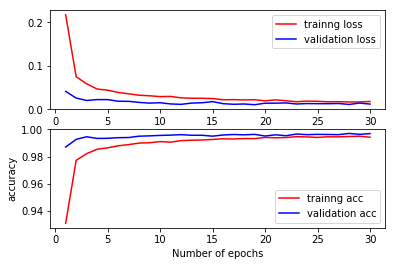

In [19]:
fig,ax=plt.subplots(2,1)
fig.set
x=range(1,1+epochs)
ax[0].plot(x,history.history['loss'],color='red')
ax[0].plot(x,history.history['val_loss'],color='blue')

ax[1].plot(x,history.history['accuracy'],color='red')
ax[1].plot(x,history.history['val_accuracy'],color='blue')
ax[0].legend(['trainng loss','validation loss'])
ax[1].legend(['trainng acc','validation acc'])
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')


绘制了模型性能的图表。可以看到，X轴表示训练的轮数（epochs），Y轴表示模型性能的变化。

### 绘制混淆矩阵



In [20]:
y_pre_test=model.predict(X_test)
y_pre_test=np.argmax(y_pre_test,axis=1)
y_test=np.argmax(y_test,axis=1)


In [21]:
conf=confusion_matrix(y_test,y_pre_test)
conf=pd.DataFrame(conf,index=range(0,10),columns=range(0,10))



In [22]:
conf

,0,1,2,3,4,5,6,7,8,9
0,853,5,0,0,0,0,0,0,0,0
1,0,913,0,0,0,0,0,0,0,0
2,1,0,907,0,0,0,0,0,0,0
3,0,0,0,884,0,0,0,6,0,0
4,0,0,0,0,923,0,0,0,3,0
5,0,0,0,2,1,871,0,0,0,0
6,0,0,0,0,0,0,859,2,0,1
7,0,0,0,1,0,0,2,930,0,0
8,0,0,0,0,0,0,0,0,918,0
9,1,0,0,0,0,0,3,0,0,914


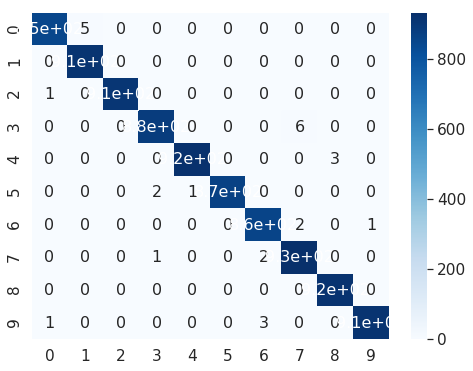

In [23]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf, annot=True,annot_kws={"size": 16},cmap=plt.cm.Blues)# font size

在这里，可以看到模型在几乎所有数字上表现得相当不错。但是似乎在以下几对数字之间存在一些混淆：

- 0 和 1：我们可以观察到一些0和1被错误分类。
- 7 和 6：我们可以观察到一些6和7被错误分类。

## 进一步调查

继续查看一些被错误分类的图像，并将简单地检查它们，以了解它们是否是难以预测的情况。

In [24]:
x=(y_pre_test-y_test!=0).tolist()
x=[i for i,l in enumerate(x) if l!=False]

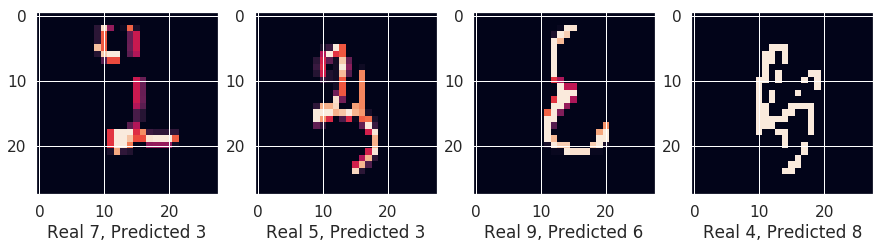

In [25]:
fig,ax=plt.subplots(1,4,sharey=False,figsize=(15,15))

for i in range(4):
    ax[i].imshow(X_test[x[i]][:,:,0])
    ax[i].set_xlabel('Real {}, Predicted {}'.format(y_test[x[i]],y_pre_test[x[i]]))



## 提交数据


In [26]:
test=pd.read_csv('../input/Kannada-MNIST/test.csv')

In [27]:
test_id=test.id

test=test.drop('id',axis=1)
test=test/255
test=test.values.reshape(-1,28,28,1)


In [28]:
test.shape

(5000, 28, 28, 1)

In [29]:
y_pre=model.predict(test)     # 预测结果
y_pre=np.argmax(y_pre,axis=1) # 改变预测为标签

In [30]:
sample_sub['label']=y_pre
sample_sub.to_csv('submission.csv',index=False)


In [31]:
sample_sub.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
